# Using Autoencoders to Identify Normal and Abnormal Traffic Behavior in Netflow Data

## Goal

Train an autoencoder neural network to develop lower-dimensional representations of netflow data in an attempt to identify categories of behavior present within the data and effectively differentiate between abnormal and normal behavior.

Now when I say lower-dimensional representation (aka an embedding), what I mean by this is basically a fingerprint. So what I'm searching for is a way to take all the features of raw netflow data and really distill it down into key components that identify and classify the data.
![](https://media.istockphoto.com/videos/fingerprint-binary-code-video-id467425199?s=640x640)

## Intro to Unsupervised Learning and Autoencoders

An autoencoder is a type of unsupervised learning algorithm. 

**What do I mean by an unsupervised learning algorithm?** 
An unsupervised learning algorithm takes in unlabeled or unclassified data, and attempts to develop its own labels/classifications. An easy way to think of this is showing an algorithm a bunch of images of cartoon characters but not telling the alogorithm which character is which. While training the algorithm, it attempts to place the characters into it's own groups based on the similarities inherent in each image. Below our algorithm has clearly discovered two beloved types of cartoon charaters: Duck and not-Duck!
![](https://miro.medium.com/max/1234/1*6hfFWPITJxbtw4ztoC1YeA.png)

Specifically, an autoencoder is a type of neural network algorithm that attempts to reproduce the input that is passed into its input layer. 
![alt text](https://cdn-images-1.medium.com/max/800/1*2ijh2-e0PcYgYKbWYkbdsw.png "From https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf")
Initially this may sound unimpressive and indeed, if we allow our encoding to be the same size as the input, our algorithm could easily learn to simply memorize the input values!  


![alt text](https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-06-at-6.09.05-PM.png "From https://www.jeremyjordan.me/autoencoders/")
However, by imposing a bottleneck in the network we can force a compressed knowledge representation of the original input (i.e. we can boil the input data down to its essential pieces or its fingerprint). If the input features were each independent of one another, this compression and subsequent reconstruction would be a very difficult task. However, if some sort of structure exists in the data (ie. correlations between input features), this structure can be learned and consequently leveraged when forcing the input through the network's bottleneck.
![alt text](https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-06-at-3.17.13-PM.png "From https://www.jeremyjordan.me/autoencoders/")


## Download the data

The dataset I'll be using for this project is the LANL 2017 netflow dataset and focusing my initial analysis on day-03. There are about 6.1 million entries or 'events' that occur on day-03, each with 11 fields of data:

In [1]:
import os
import pandas as pd

DIR = "../input"

colnames = ['Time', 'Duration', 'SrcDevice', 'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 
       'DstPackets', 'SrcBytes', 'DstBytes']
cat_vars = ['SrcDevice', 'DstDevice','Protocol','SrcPort', 'DstPort']
cont_vars = ['Time', 'Duration', 'SrcPackets', 'DstPackets', 'SrcBytes', 'DstBytes']
train_df = pd.read_csv(os.path.join(DIR, 'netflow_day-03.csv'),names = colnames)
train_df.head()

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
0,172800,0,Comp348305,Comp370444,6,Port02726,80,0,5,0,784
1,172800,0,Comp817584,Comp275646,17,Port97545,53,1,0,77,0
2,172800,0,Comp654013,Comp685925,6,Port26890,Port94857,6,5,1379,1770
3,172800,0,Comp500631,Comp275646,17,Port62938,53,1,0,64,0
4,172800,0,Comp500631,Comp275646,17,Port52912,53,1,0,64,0


In [ ]:
%wget -c https://csr.lanl.gov/data/unified-host-network-dataset-2017/netflow/netflow_day-03.bz2

| Field Name    | Description                                                |
| ------------- |:----------------------------------------------------------:|
| Time          | The start time of the event in epoch time format.          |
| Duration      | The duration of the event in seconds.                      |  
| SrcDevice	    | The device that likely initiated the event.                |
| DstDevice	    | The receiving device.                                      | 
| Protocol	    | The protocol number.                                       |
| SrcPort	    | The port used by the SrcDevice.                            |  
| DstPort	    | The port used by the DstDevice.                            | 
| SrcPackets    | The number of packets the SrcDevice sent during the event. | 
| DstPackets    | The number of packets the DstDevice sent during the event. | 
| SrcBytes      | The number of bytes the SrcDevice sent during the event.   | 
| DstBytes      | The number of bytes the DstDevice sent during the event.   |  

## Load the data

Each day of the LANL netflow data ends in an incomplete line. Hence attempting a simple `bunzip2` will result in a failure. To work around this issue we can use `bzip2recover` on the file, use `bzip2` to unzip the individual blocks and stich them together into a single csv file and finally use a quick bash command to remove the corrupted final line.

In [ ]:
%bzip2recover netflow_day-03.bz2
%bzip2 -dc rec00* > netflow_day-03.csv
%head -n -1 netflow_day-03.csv > temp.txt ; mv temp.txt netflow_day-03.csv
%mkdir ../input
%mv netflow_day-03.csv ../input/

## Data Exploration

### Initial look

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

| Field Name    | Description                                                |
| ------------- |:----------------------------------------------------------:|
| Time          | The start time of the event in epoch time format.          |
| Duration      | The duration of the event in seconds.                      |  
| SrcDevice	    | The device that likely initiated the event.                |
| DstDevice	    | The receiving device.                                      | 
| Protocol	    | The protocol number.                                       |
| SrcPort	    | The port used by the SrcDevice.                            |  
| DstPort	    | The port used by the DstDevice.                            | 
| SrcPackets    | The number of packets the SrcDevice sent during the event. | 
| DstPackets    | The number of packets the DstDevice sent during the event. | 
| SrcBytes      | The number of bytes the SrcDevice sent during the event.   | 
| DstBytes      | The number of bytes the DstDevice sent during the event.   |  

In [3]:
DIR = "../input"

colnames = ['Time', 'Duration', 'SrcDevice', 'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 
       'DstPackets', 'SrcBytes', 'DstBytes']
cat_vars = ['SrcDevice', 'DstDevice','Protocol','SrcPort', 'DstPort']
cont_vars = ['Time', 'Duration', 'SrcPackets', 'DstPackets', 'SrcBytes', 'DstBytes']
train_df = pd.read_csv(os.path.join(DIR, 'netflow_day-03.csv'),names = colnames)

We've got a little over 6.1 million events occuring during day-03 in our dataset.

In [45]:
train_df.shape

(6102087, 11)

In [35]:
train_df.head()

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
0,172800,0,Comp348305,Comp370444,6,Port02726,80,0,5,0,784
1,172800,0,Comp817584,Comp275646,17,Port97545,53,1,0,77,0
2,172800,0,Comp654013,Comp685925,6,Port26890,Port94857,6,5,1379,1770
3,172800,0,Comp500631,Comp275646,17,Port62938,53,1,0,64,0
4,172800,0,Comp500631,Comp275646,17,Port52912,53,1,0,64,0


Let's get an idea of the number of unique values for a few of the features.  `SrcDevice` and `DstDevice` each have roughly 19K unique values. `SrcPort` has roughly 65K unique values while `DstPort` has roughly 40K unique values. 

(Technical Aside: This high cardinality means its difficult to take advantage of a one-hot-encoding scheme for these 4 variables although we will be able to break apart `SrcDevice` and `DstDevice` for some more information as I will show below. **Question: Are Comp/IP/Port numbers near one another are related in their uses?** For now I'll treat them as categorical. Protocol only has 3 different values, so we can easily one-hot-encode that variable (1=ICMP Internet Control Message, 6=TCP Transmission Control, 17=UDP User Datagram).) 

### `SrcDevice` and `DstDevice`

#### There are 6 general categories of Devices: `Comp`, `IP`, `ActiveDirectory`, `EnterpriseAppServer`, `VPN` and `VScanner`.

In [45]:
train_df['SrcDevice'].astype('category').cat.categories

Index(['ActiveDirectory', 'Comp000116', 'Comp000156', 'Comp000219',
       'Comp000566', 'Comp000573', 'Comp000577', 'Comp000688', 'Comp000696',
       'Comp000775',
       ...
       'IP998111', 'IP998491', 'IP998759', 'IP998823', 'IP999095', 'IP999633',
       'IP999839', 'IP999955', 'VPN', 'VScanner'],
      dtype='object', length=18950)

In [22]:
train_df['DstDevice'].astype('category').cat.categories

Index(['ActiveDirectory', 'Comp000190', 'Comp000244', 'Comp000332',
       'Comp000346', 'Comp000386', 'Comp000575', 'Comp000595', 'Comp000688',
       'Comp000944',
       ...
       'IP999711', 'IP999776', 'IP999780', 'IP999852', 'IP999875', 'IP999896',
       'IP999935', 'IP999949', 'VPN', 'VScanner'],
      dtype='object', length=18921)

There are a few other Devices beyond Comps and IPs.

In [5]:
noComp_orIP = train_df['SrcDevice'].loc[(train_df['SrcDevice'].str.contains('Comp')==False) &
                          (train_df['SrcDevice'].str.contains('IP')==False)].astype('category').cat.categories
print(noComp_orIP)

Index(['ActiveDirectory', 'EnterpriseAppServer', 'VPN', 'VScanner'], dtype='object')


#### The majority (98%) of events appear to have a `SrcDevice` that is a Comp. The next closest Device is the `EnterpriseAppServer` at 1.37% of events. It's also interesting to note that 8 Comps are the `SrcDevice` of nearly half the data.

In [46]:
print('Events\' SrcDevice Breakdown')
for i in ['Comp','IP','ActiveDirectory', 'EnterpriseAppServer', 'VPN', 'VScanner']:
    tmp = train_df['SrcDevice'].loc[(train_df['SrcDevice'].str.contains(f'{i}')==True)].count()/train_df['Time'].count()
    print(i,tmp)

SrcDevice Breakdown
Comp 0.9766106251844656
IP 0.0033899877205946097
ActiveDirectory 0.0014785105489318654
EnterpriseAppServer 0.013733498063859135
VPN 0.0011150283501366008
VScanner 0.0036723501320122115


In [57]:
counted = train_df1.groupby("SrcDevice_Comp").count().rename(columns={"Time":"SrcDevice_count"})
counted.sort_values(by=['SrcDevice_count'],ascending=False).head(10)

,SrcDevice_count,Duration,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes,DstDevice_Comp,SrcDevice_IP,...,DstDevice_ActiveDirectory,SrcDevice_EnterpriseAppServer,DstDevice_EnterpriseAppServer,SrcDevice_VPN,DstDevice_VPN,SrcDevice_VScanner,DstDevice_VScanner,Protocol_1,Protocol_6,Protocol_17
SrcDevice_Comp,,,,,,,,,,,,,,,,,,,,,
44772,412110,412110,412110,412110,412110,412110,412110,412110,412110,412110,...,412110,412110,412110,412110,412110,412110,412110,412110,412110,412110
296454,396393,396393,396393,396393,396393,396393,396393,396393,396393,396393,...,396393,396393,396393,396393,396393,396393,396393,396393,396393,396393
623258,376489,376489,376489,376489,376489,376489,376489,376489,376489,376489,...,376489,376489,376489,376489,376489,376489,376489,376489,376489,376489
73202,355912,355912,355912,355912,355912,355912,355912,355912,355912,355912,...,355912,355912,355912,355912,355912,355912,355912,355912,355912,355912
30334,343163,343163,343163,343163,343163,343163,343163,343163,343163,343163,...,343163,343163,343163,343163,343163,343163,343163,343163,343163,343163
866402,342651,342651,342651,342651,342651,342651,342651,342651,342651,342651,...,342651,342651,342651,342651,342651,342651,342651,342651,342651,342651
257274,342549,342549,342549,342549,342549,342549,342549,342549,342549,342549,...,342549,342549,342549,342549,342549,342549,342549,342549,342549,342549
965575,337894,337894,337894,337894,337894,337894,337894,337894,337894,337894,...,337894,337894,337894,337894,337894,337894,337894,337894,337894,337894
0,142724,142724,142724,142724,142724,142724,142724,142724,142724,142724,...,142724,142724,142724,142724,142724,142724,142724,142724,142724,142724


#### While the majority of events have a Comp for their `DstDevice` (86.61%), `ActiveDirectory` and `EnterpriseAppServer` have a larger share than for the `SrcDevice` (7.14% and 5.85% respectively).

In [47]:
print('Events\' DstDevice Breakdown')
for i in ['Comp','IP','ActiveDirectory', 'EnterpriseAppServer', 'VPN', 'VScanner']:
    tmp = train_df['DstDevice'].loc[(train_df['DstDevice'].str.contains(f'{i}')==True)].count()/train_df['Time'].count()
    print(i,tmp)

DstDevice Breakdown
Comp 0.8661133477775719
IP 0.0035854946020926937
ActiveDirectory 0.07141753305057762
EnterpriseAppServer 0.05854111880082995
VPN 0.00013454413219608308
VScanner 0.00020796163673182633


In [58]:
counted = train_df1.groupby("DstDevice_Comp").count().rename(columns={"Time":"DstDevice_count"})
counted.sort_values(by=['DstDevice_count'],ascending=False).head(10)

,DstDevice_count,Duration,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes,SrcDevice_Comp,SrcDevice_IP,...,DstDevice_ActiveDirectory,SrcDevice_EnterpriseAppServer,DstDevice_EnterpriseAppServer,SrcDevice_VPN,DstDevice_VPN,SrcDevice_VScanner,DstDevice_VScanner,Protocol_1,Protocol_6,Protocol_17
DstDevice_Comp,,,,,,,,,,,,,,,,,,,,,
0,816988,816988,816988,816988,816988,816988,816988,816988,816988,816988,...,816988,816988,816988,816988,816988,816988,816988,816988,816988,816988
275646,624576,624576,624576,624576,624576,624576,624576,624576,624576,624576,...,624576,624576,624576,624576,624576,624576,624576,624576,624576,624576
576031,218410,218410,218410,218410,218410,218410,218410,218410,218410,218410,...,218410,218410,218410,218410,218410,218410,218410,218410,218410,218410
576843,193316,193316,193316,193316,193316,193316,193316,193316,193316,193316,...,193316,193316,193316,193316,193316,193316,193316,193316,193316,193316
186884,145802,145802,145802,145802,145802,145802,145802,145802,145802,145802,...,145802,145802,145802,145802,145802,145802,145802,145802,145802,145802
916004,66911,66911,66911,66911,66911,66911,66911,66911,66911,66911,...,66911,66911,66911,66911,66911,66911,66911,66911,66911,66911
63824,63126,63126,63126,63126,63126,63126,63126,63126,63126,63126,...,63126,63126,63126,63126,63126,63126,63126,63126,63126,63126
393033,44319,44319,44319,44319,44319,44319,44319,44319,44319,44319,...,44319,44319,44319,44319,44319,44319,44319,44319,44319,44319
501516,43614,43614,43614,43614,43614,43614,43614,43614,43614,43614,...,43614,43614,43614,43614,43614,43614,43614,43614,43614,43614


#### There doesn't seem to be anything particularly interesting in the distribution of Comp numbers for `SrcDevice` or `DstDevice`. Again we see that a select few Comps have a majoirty of the traffic.

/home/paperspace/anaconda3/envs/fastaiv1/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


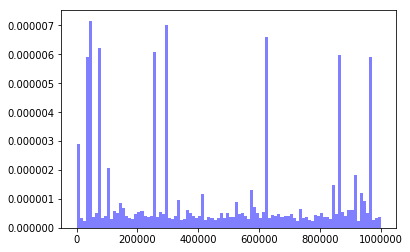

In [85]:
num_bins = 100
plt.hist(train_df1['SrcDevice_Comp'], num_bins, normed=1, facecolor='blue', alpha=0.5)
plt.show()

/home/paperspace/anaconda3/envs/fastaiv1/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


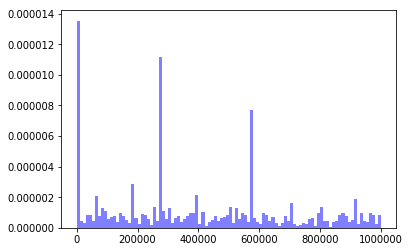

In [88]:
num_bins = 100
plt.hist(train_df1['DstDevice_Comp'], num_bins, normed=1, facecolor='blue', alpha=0.5)
plt.show()

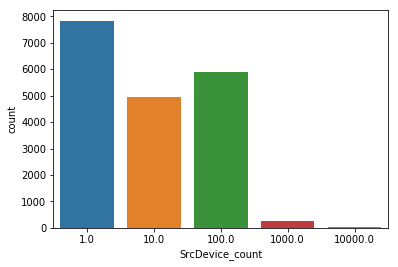

In [44]:
for i in np.logspace(0,4,5):
    if i != 1e4:
        counted.loc[(counted["SrcDevice_count"] > i) & (counted["SrcDevice_count"] < i*10),'SrcDevice_count'] = i
    else:
        counted.loc[counted["SrcDevice_count"] > i,'SrcDevice_count'] = i
plt.figure()
sns.countplot(data=counted, x="SrcDevice_count")
plt.show()

Looking at the distribution of `SrcDevice`, it appears that the majority (98.401%) of `SrcDevices` are used anywhere from 1 to 1000 times but only accoutn for a quarter the data! Another quarter of the data account for 1.557% `SrcDevices` used between 1000 and 1e5 times and nearly half of the data originates from 0.042% (8!!) of `SrcDevices`.

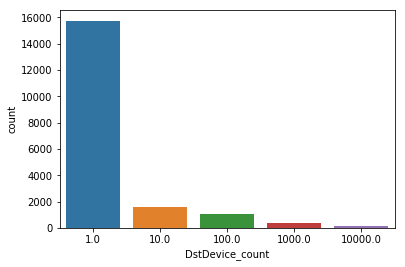

In [45]:
counted = train_df.groupby("DstDevice").count().rename(columns={"Time":"DstDevice_count"})
for i in np.logspace(0,4,5):
    if i != 1e4:
        counted.loc[(counted["DstDevice_count"] > i) & (counted["DstDevice_count"] < i*10),'DstDevice_count'] = i
    else:
        counted.loc[counted["DstDevice_count"] > i,'DstDevice_count'] = i
plt.figure()
sns.countplot(data=counted, x="DstDevice_count")
plt.show()

In [38]:
for i in np.logspace(1,3,3):
    print(i, len(counted['Duration'].loc[counted['Duration']>i].values))

10.0 10997
100.0 6131
1000.0 303


In [53]:
train_df.head()

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
0,172800,0,4420,2456,1,1926,224,0,5,0,784
1,172800,0,10428,1828,2,63323,155,1,0,77,0
2,172800,0,8268,4593,1,17434,37537,6,5,1379,1770
3,172800,0,6348,1828,2,40895,155,1,0,64,0
4,172800,0,6348,1828,2,34386,155,1,0,64,0


#### Attempt at showing clusters of devices through a flow graph (Work in progress!!)

In [122]:
import igraph as ig
train_df0 = pd.read_csv(os.path.join(DIR, 'netflow_day-03.csv'),names = colnames)

In [123]:
flow = train_df0.groupby(['SrcDevice','DstDevice']).size().reset_index().rename(columns={0:'count'})

In [124]:
computer_edgelist = dict(zip(map(tuple,flow[['SrcDevice','DstDevice']].values.tolist()),flow['count'].values.tolist()))

In [126]:
src_set = set([x[0][0] for x in computer_edgelist.items()])
dst_set = set([x[0][1] for x in computer_edgelist.items()])

print("Sources:     ", len(src_set))
print("Destinations: ", len(dst_set))
print("Union:       ", len(src_set.union(dst_set)))
print("Intersection: ", len(src_set.intersection(dst_set)))

Sources:      18950
Destinations:  18921
Union:        34019
Intersection:  3852


In [128]:
nv = len(src_set.union(dst_set))
vlookup = dict(zip(range(nv), list(src_set.union(dst_set))))
ilookup = dict(zip(list(src_set.union(dst_set)), range(nv)))
elist = [[ilookup[k[0]], ilookup[k[1]]] for k in computer_edgelist.keys()]

flow_graph = ig.Graph(nv)
flow_graph.add_edges(elist)

flow_graph.is_connected()

False

![alt text](https://github.com/box121209/LANL-analysis/raw/4102f12c070b2d8ef595585d9471ea514b202058/img/icmp_graph.png )

### `Protocol`

#### Protocol 6 (TCP) accounts for over 77.69% of events, Protocol 17 (UDP) accounts for 22.28% while Protocol 1 (ICMP) only accounts for .03%.

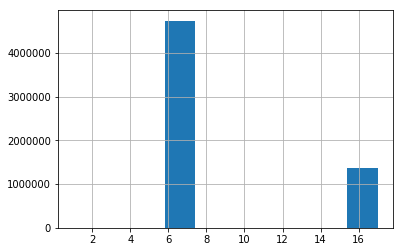

In [72]:
train_df['Protocol'].hist()

In [76]:
train_df['Protocol'].loc[train_df['Protocol']==17].count()/train_df['Time'].count()

0.22279705287715498

### `SrcPort` and `DstPort`

#### Distribution across `SrcPort` seems nearly uniform.

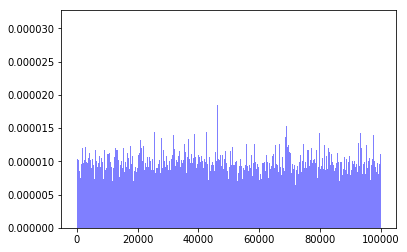

In [91]:
num_bins = 1000
plt.hist(train_df1['SrcPort'], num_bins, density=True, facecolor='blue', alpha=0.5)
plt.show()

#### `DstPort` is another story. The top 10 `DstPorts` account for over half of the events

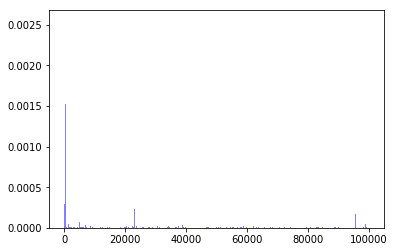

In [107]:
num_bins = 1000
plt.hist(train_df1['DstPort'], num_bins, density=True, facecolor='blue', alpha=0.5)
plt.show()

In [109]:
counted = train_df1.groupby("DstPort").count().rename(columns={"Time":"DstPort_count"})
counted.sort_values(by=['DstPort_count'],ascending=False).head(10)

,DstPort_count,Duration,SrcPort,SrcPackets,DstPackets,SrcBytes,DstBytes,SrcDevice_Comp,DstDevice_Comp,SrcDevice_IP,...,DstDevice_ActiveDirectory,SrcDevice_EnterpriseAppServer,DstDevice_EnterpriseAppServer,SrcDevice_VPN,DstDevice_VPN,SrcDevice_VScanner,DstDevice_VScanner,Protocol_1,Protocol_6,Protocol_17
DstPort,,,,,,,,,,,,,,,,,,,,,
53,750295,750295,750295,750295,750295,750295,750295,750295,750295,750295,...,750295,750295,750295,750295,750295,750295,750295,750295,750295,750295
443,700175,700175,700175,700175,700175,700175,700175,700175,700175,700175,...,700175,700175,700175,700175,700175,700175,700175,700175,700175,700175
80,607732,607732,607732,607732,607732,607732,607732,607732,607732,607732,...,607732,607732,607732,607732,607732,607732,607732,607732,607732,607732
514,264663,264663,264663,264663,264663,264663,264663,264663,264663,264663,...,264663,264663,264663,264663,264663,264663,264663,264663,264663,264663
389,213198,213198,213198,213198,213198,213198,213198,213198,213198,213198,...,213198,213198,213198,213198,213198,213198,213198,213198,213198,213198
88,162582,162582,162582,162582,162582,162582,162582,162582,162582,162582,...,162582,162582,162582,162582,162582,162582,162582,162582,162582,162582
23118,137832,137832,137832,137832,137832,137832,137832,137832,137832,137832,...,137832,137832,137832,137832,137832,137832,137832,137832,137832,137832
427,113420,113420,113420,113420,113420,113420,113420,113420,113420,113420,...,113420,113420,113420,113420,113420,113420,113420,113420,113420,113420
95765,99594,99594,99594,99594,99594,99594,99594,99594,99594,99594,...,99594,99594,99594,99594,99594,99594,99594,99594,99594,99594


In [117]:
sum(counted.sort_values(by=['DstPort_count'],ascending=False)['DstPort_count'].values[:10])

3148511

### `SrcPackets` and `DstPackets`

#### 91.47% of events send between 0-10 packets from the `SrcDevice`. The highest amount of packets sent is 87701075!

In [144]:
counted = train_df1.groupby("SrcPackets").count().rename(columns={"Time":"SrcPackets_count"})
counted.sort_values(by=['SrcPackets_count'],ascending=False).head(10)

,SrcPackets_count,Duration,SrcPort,DstPort,DstPackets,SrcBytes,DstBytes,SrcDevice_Comp,DstDevice_Comp,SrcDevice_IP,...,DstDevice_ActiveDirectory,SrcDevice_EnterpriseAppServer,DstDevice_EnterpriseAppServer,SrcDevice_VPN,DstDevice_VPN,SrcDevice_VScanner,DstDevice_VScanner,Protocol_1,Protocol_6,Protocol_17
SrcPackets,,,,,,,,,,,,,,,,,,,,,
0,1951332,1951332,1951332,1951332,1951332,1951332,1951332,1951332,1951332,1951332,...,1951332,1951332,1951332,1951332,1951332,1951332,1951332,1951332,1951332,1951332
1,1181225,1181225,1181225,1181225,1181225,1181225,1181225,1181225,1181225,1181225,...,1181225,1181225,1181225,1181225,1181225,1181225,1181225,1181225,1181225,1181225
5,600726,600726,600726,600726,600726,600726,600726,600726,600726,600726,...,600726,600726,600726,600726,600726,600726,600726,600726,600726,600726
4,537638,537638,537638,537638,537638,537638,537638,537638,537638,537638,...,537638,537638,537638,537638,537638,537638,537638,537638,537638,537638
3,245588,245588,245588,245588,245588,245588,245588,245588,245588,245588,...,245588,245588,245588,245588,245588,245588,245588,245588,245588,245588
2,233467,233467,233467,233467,233467,233467,233467,233467,233467,233467,...,233467,233467,233467,233467,233467,233467,233467,233467,233467,233467
6,184014,184014,184014,184014,184014,184014,184014,184014,184014,184014,...,184014,184014,184014,184014,184014,184014,184014,184014,184014,184014
10,183998,183998,183998,183998,183998,183998,183998,183998,183998,183998,...,183998,183998,183998,183998,183998,183998,183998,183998,183998,183998
11,171049,171049,171049,171049,171049,171049,171049,171049,171049,171049,...,171049,171049,171049,171049,171049,171049,171049,171049,171049,171049


In [145]:
sum(counted.sort_values(by=['SrcPackets_count'],ascending=False)['SrcPackets_count'].values[:12])/sum(counted.sort_values(by=['SrcPackets_count'],ascending=False)['SrcPackets_count'].values)

0.9146632947055655

In [136]:
np.sort(train_df1['SrcPackets'].values)[-10:]

array([72759509, 74938675, 77148736, 79109660, 81076770, 82796324,
       84609078, 84760288, 86720597, 87701075])

#### 93.40% of events send between 0-10 packets from the `DstDevice`. The highest amount of packets sent is 77760718.

In [139]:
counted = train_df1.groupby("DstPackets").count().rename(columns={"Time":"DstPackets_count"})
counted.sort_values(by=['DstPackets_count'],ascending=False).head(10)

,DstPackets_count,Duration,SrcPort,DstPort,SrcPackets,SrcBytes,DstBytes,SrcDevice_Comp,DstDevice_Comp,SrcDevice_IP,...,DstDevice_ActiveDirectory,SrcDevice_EnterpriseAppServer,DstDevice_EnterpriseAppServer,SrcDevice_VPN,DstDevice_VPN,SrcDevice_VScanner,DstDevice_VScanner,Protocol_1,Protocol_6,Protocol_17
DstPackets,,,,,,,,,,,,,,,,,,,,,
0,2098503,2098503,2098503,2098503,2098503,2098503,2098503,2098503,2098503,2098503,...,2098503,2098503,2098503,2098503,2098503,2098503,2098503,2098503,2098503,2098503
1,1746836,1746836,1746836,1746836,1746836,1746836,1746836,1746836,1746836,1746836,...,1746836,1746836,1746836,1746836,1746836,1746836,1746836,1746836,1746836,1746836
3,596994,596994,596994,596994,596994,596994,596994,596994,596994,596994,...,596994,596994,596994,596994,596994,596994,596994,596994,596994,596994
5,283068,283068,283068,283068,283068,283068,283068,283068,283068,283068,...,283068,283068,283068,283068,283068,283068,283068,283068,283068,283068
2,218062,218062,218062,218062,218062,218062,218062,218062,218062,218062,...,218062,218062,218062,218062,218062,218062,218062,218062,218062,218062
4,196227,196227,196227,196227,196227,196227,196227,196227,196227,196227,...,196227,196227,196227,196227,196227,196227,196227,196227,196227,196227
7,189765,189765,189765,189765,189765,189765,189765,189765,189765,189765,...,189765,189765,189765,189765,189765,189765,189765,189765,189765,189765
6,120250,120250,120250,120250,120250,120250,120250,120250,120250,120250,...,120250,120250,120250,120250,120250,120250,120250,120250,120250,120250
9,68150,68150,68150,68150,68150,68150,68150,68150,68150,68150,...,68150,68150,68150,68150,68150,68150,68150,68150,68150,68150


In [142]:
sum(counted.sort_values(by=['DstPackets_count'],ascending=False)['DstPackets_count'].values[:12])/sum(counted.sort_values(by=['DstPackets_count'],ascending=False)['DstPackets_count'].values)

0.9340995957612535

In [161]:
np.sort(train_df1['DstPackets'].values)[-10:]

array([64687095, 66650395, 68478386, 68610780, 70356457, 71882842,
       73626605, 75365457, 77107098, 77760718])

### `SrcBytes` and `DstBytes`

#### Initial Look

In [147]:
counted = train_df1.groupby("SrcBytes").count().rename(columns={"Time":"SrcBytes_count"})
counted.sort_values(by=['SrcBytes_count'],ascending=False).head(10)

,SrcBytes_count,Duration,SrcPort,DstPort,SrcPackets,DstPackets,DstBytes,SrcDevice_Comp,DstDevice_Comp,SrcDevice_IP,...,DstDevice_ActiveDirectory,SrcDevice_EnterpriseAppServer,DstDevice_EnterpriseAppServer,SrcDevice_VPN,DstDevice_VPN,SrcDevice_VScanner,DstDevice_VScanner,Protocol_1,Protocol_6,Protocol_17
SrcBytes,,,,,,,,,,,,,,,,,,,,,
0,1951332,1951332,1951332,1951332,1951332,1951332,1951332,1951332,1951332,1951332,...,1951332,1951332,1951332,1951332,1951332,1951332,1951332,1951332,1951332,1951332
277,268365,268365,268365,268365,268365,268365,268365,268365,268365,268365,...,268365,268365,268365,268365,268365,268365,268365,268365,268365,268365
216,266771,266771,266771,266771,266771,266771,266771,266771,266771,266771,...,266771,266771,266771,266771,266771,266771,266771,266771,266771,266771
60,247876,247876,247876,247876,247876,247876,247876,247876,247876,247876,...,247876,247876,247876,247876,247876,247876,247876,247876,247876,247876
225,112601,112601,112601,112601,112601,112601,112601,112601,112601,112601,...,112601,112601,112601,112601,112601,112601,112601,112601,112601,112601
164,99908,99908,99908,99908,99908,99908,99908,99908,99908,99908,...,99908,99908,99908,99908,99908,99908,99908,99908,99908,99908
399,77662,77662,77662,77662,77662,77662,77662,77662,77662,77662,...,77662,77662,77662,77662,77662,77662,77662,77662,77662,77662
152,74380,74380,74380,74380,74380,74380,74380,74380,74380,74380,...,74380,74380,74380,74380,74380,74380,74380,74380,74380,74380
46,71063,71063,71063,71063,71063,71063,71063,71063,71063,71063,...,71063,71063,71063,71063,71063,71063,71063,71063,71063,71063


In [128]:
np.sort(train_df['SrcBytes'].values)[-10:]

array([12122909246, 12459931268, 12832178150, 13209994822, 13545567320,
       13882204590, 14176496098, 14513284176, 14848224144, 15015712600])

In [149]:
counted = train_df1.groupby("DstBytes").count().rename(columns={"Time":"DstBytes_count"})
counted.sort_values(by=['DstBytes_count'],ascending=False).head(10)

,DstBytes_count,Duration,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,SrcDevice_Comp,DstDevice_Comp,SrcDevice_IP,...,DstDevice_ActiveDirectory,SrcDevice_EnterpriseAppServer,DstDevice_EnterpriseAppServer,SrcDevice_VPN,DstDevice_VPN,SrcDevice_VScanner,DstDevice_VScanner,Protocol_1,Protocol_6,Protocol_17
DstBytes,,,,,,,,,,,,,,,,,,,,,
0,2098503,2098503,2098503,2098503,2098503,2098503,2098503,2098503,2098503,2098503,...,2098503,2098503,2098503,2098503,2098503,2098503,2098503,2098503,2098503,2098503
46,1500887,1500887,1500887,1500887,1500887,1500887,1500887,1500887,1500887,1500887,...,1500887,1500887,1500887,1500887,1500887,1500887,1500887,1500887,1500887,1500887
164,224058,224058,224058,224058,224058,224058,224058,224058,224058,224058,...,224058,224058,224058,224058,224058,224058,224058,224058,224058,224058
3911,71773,71773,71773,71773,71773,71773,71773,71773,71773,71773,...,71773,71773,71773,71773,71773,71773,71773,71773,71773,71773
479,57954,57954,57954,57954,57954,57954,57954,57954,57954,57954,...,57954,57954,57954,57954,57954,57954,57954,57954,57954,57954
112,55094,55094,55094,55094,55094,55094,55094,55094,55094,55094,...,55094,55094,55094,55094,55094,55094,55094,55094,55094,55094
106,53733,53733,53733,53733,53733,53733,53733,53733,53733,53733,...,53733,53733,53733,53733,53733,53733,53733,53733,53733,53733
177,39591,39591,39591,39591,39591,39591,39591,39591,39591,39591,...,39591,39591,39591,39591,39591,39591,39591,39591,39591,39591
1503,38017,38017,38017,38017,38017,38017,38017,38017,38017,38017,...,38017,38017,38017,38017,38017,38017,38017,38017,38017,38017


In [129]:
np.sort(train_df['DstBytes'].values)[-10:]

array([11146902232, 11457059168, 11805619364, 12153021664, 12461839686,
       12732086028, 13040875936, 13348384456, 13657486438, 13773586368])

#### Question: As someone new to the field, I'm uncertain why the number of bytes for events jumps from 0 to 42.

In [125]:
unique_df = np.unique(train_df['DstBytes'].values)
np.sort(unique_df)[:10]

array([ 0, 42, 44, 46, 48, 49, 52, 55, 56, 58])

In [126]:
unique_df = np.unique(train_df['SrcBytes'].values)
np.sort(unique_df)[:10]

array([ 0, 42, 44, 46, 47, 48, 49, 50, 51, 52])

#### Distributions of `Packets` and `Bytes` seem to follow a power law which appears to be normal.

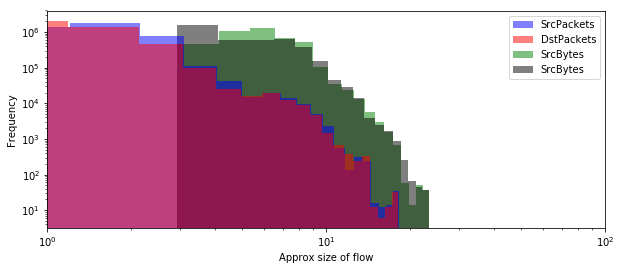

In [110]:
num_bins = 20
plt.figure(figsize=(10,4))
plt.xscale('log')
plt.yscale('log')
plt.hist(np.log(train_df['SrcPackets'].values+0.5), num_bins, facecolor='blue', alpha=0.5,log=True, label = 'SrcPackets')
plt.hist(np.log(train_df['DstPackets'].values+0.5), num_bins, facecolor='red', alpha=0.5,log=True, label = 'DstPackets')
plt.hist(np.log(train_df['SrcBytes'].values+0.5), num_bins, facecolor='green', alpha=0.5,log=True, label = 'SrcBytes', zorder=-1)
plt.hist(np.log(train_df['DstBytes'].values+0.5), num_bins, facecolor='black', alpha=0.5,log=True, label = 'SrcBytes', zorder=-1)
plt.xlabel("Size") 
plt.ylabel("Count")
plt.legend( loc='upper right')
plt.xlim(1e0,1e2)
plt.show()

#### Looking at a 2d heatmap of `Packets` vs `Bytes` shows a clean linear correlation, with all flows exhibiting an average packet size (i.e. bytes/packets) between 32 and 1024 bytes.

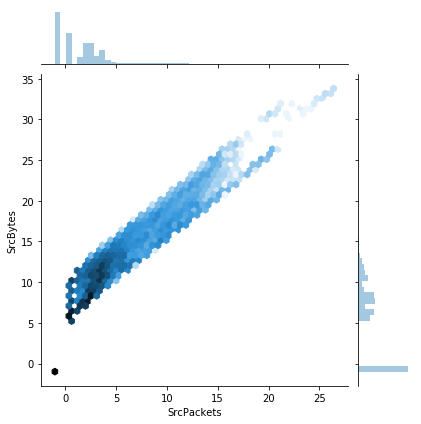

In [16]:
tdf = train_df.copy()
tdf['SrcPackets'] = np.log(tdf['SrcPackets'].values+0.5)/np.log(2)
tdf['SrcBytes'] = np.log(tdf['SrcBytes'].values+0.5)/np.log(2)
sns.jointplot(x="SrcPackets", y="SrcBytes", data=tdf, kind="hex",Norm=LogNorm())

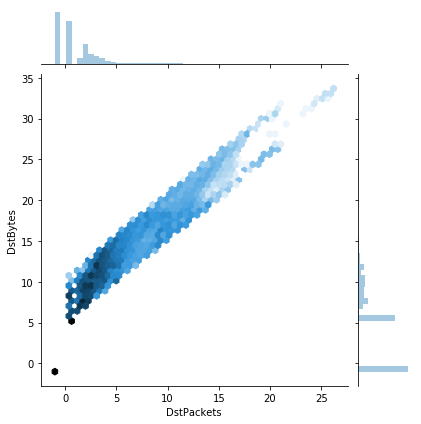

In [15]:
tdf['DstPackets'] = np.log(tdf['DstPackets'].values+0.5)/np.log(2)
tdf['DstBytes'] = np.log(tdf['DstBytes'].values+0.5)/np.log(2)
sns.jointplot(x="DstPackets", y="DstBytes", data=tdf, kind="hex",Norm = LogNorm())

### `Time` and `Duration`

#### 80% of the events last less than 1 second. The longest event took 978035 seconds or roughly 271 hours. 

In [84]:
counted = train_df.groupby("Duration").count().rename(columns={"Time":"Duration_count"})
counted.sort_values(by=['Duration_count'],ascending=False).head(10)

,Duration_count,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
Duration,,,,,,,,,,
0,2754172,2754172,2754172,2754172,2754172,2754172,2754172,2754172,2754172,2754172
1,2133800,2133800,2133800,2133800,2133800,2133800,2133800,2133800,2133800,2133800
2,80962,80962,80962,80962,80962,80962,80962,80962,80962,80962
9,68782,68782,68782,68782,68782,68782,68782,68782,68782,68782
5,59152,59152,59152,59152,59152,59152,59152,59152,59152,59152
3,36107,36107,36107,36107,36107,36107,36107,36107,36107,36107
12,34511,34511,34511,34511,34511,34511,34511,34511,34511,34511
6,28342,28342,28342,28342,28342,28342,28342,28342,28342,28342
4,28297,28297,28297,28297,28297,28297,28297,28297,28297,28297


In [159]:
sum(counted.sort_values(by=['Duration_count'],ascending=False)['Duration_count'].values[:2])/sum(counted.sort_values(by=['Duration_count'],ascending=False)['Duration_count'].values)


0.8010328269655939

In [165]:
np.sort(train_df1['Duration'].values)[-1:]/60/60

array([271.67638889])

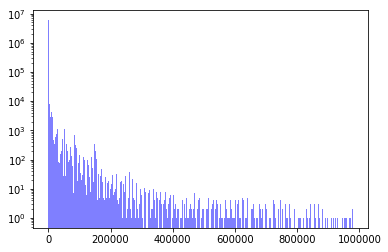

In [94]:
num_bins = 1000
plt.hist(train_df['Duration'], num_bins, facecolor='blue', alpha=0.5,log=True)
plt.show()

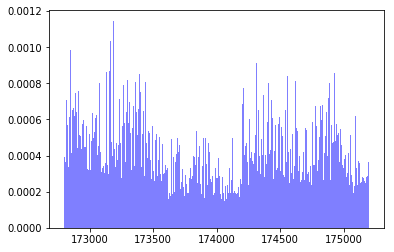

In [166]:
num_bins = 1000
plt.hist(train_df1['Time'], num_bins, density=True, facecolor='blue', alpha=0.5)
plt.show()

In [78]:
train_df.keys()

Index(['Time', 'Duration', 'SrcDevice', 'DstDevice', 'Protocol', 'SrcPort',
       'DstPort', 'SrcPackets', 'DstPackets', 'SrcBytes', 'DstBytes'],
      dtype='object')

In [ ]:
plt.figure(figsize=(10,4))
plt.yscale('log')
plt.stem(duration_hist.keys(), duration_hist.values(), markerfmt='b.')

### Normalize data

#### In order for our autoencoder to train better, it will be useful to normalize the data. I initially skipped this step and was getting astronomically high losses!

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

/home/paperspace/anaconda3/envs/fastaiv1/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int8, int16, int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/paperspace/anaconda3/envs/fastaiv1/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int8, int16, int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/paperspace/anaconda3/envs/fastaiv1/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int8, int16, int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/paperspace/anaconda3/envs/fastaiv1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[se

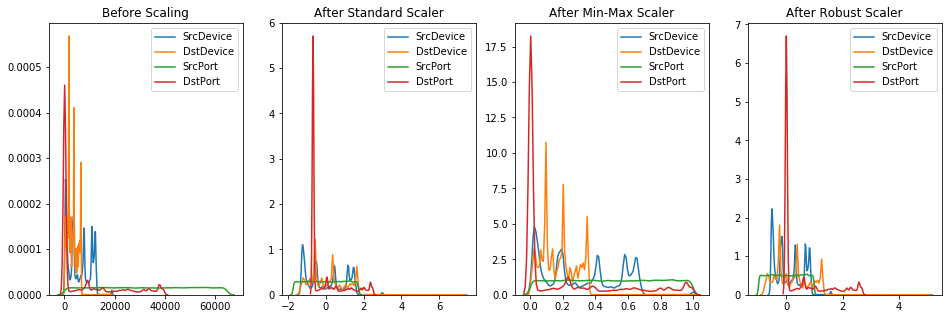

In [35]:
colnames_tsa = ['Time', 'Duration', 'SrcDevice', 'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 
        'DstPackets', 'SrcBytes', 'DstBytes', 'SrcPackets_mean1s','SrcPackets_std1s','SrcPackets_mean10s',
        'SrcPackets_std10s','SrcPackets_mean60s','SrcPackets_std60s', 'DstPackets_mean1s','DstPackets_std1s','DstPackets_mean10s',
        'DstPackets_std10s','DstPackets_mean60s','DstPackets_std60s', 'SrcBytes_mean1s','SrcBytes_std1s','SrcBytes_mean10s',
        'SrcBytes_std10s','SrcBytes_mean60s','SrcBytes_std60s', 'DstBytes_mean1s','DstBytes_std1s','DstBytes_mean10s',
        'DstBytes_std10s','DstBytes_mean60s','DstBytes_std60s',]

scaler = StandardScaler()
scaled_df = scaler.fit_transform(train_df)
scaled_df = pd.DataFrame(scaled_df, columns=colnames)
scaler1 = MinMaxScaler()
scaled_df1 = scaler1.fit_transform(train_df2)
scaled_df1 = pd.DataFrame(scaled_df1, columns=colnames_tsa)
scaler2 = RobustScaler()
scaled_df2 = scaler2.fit_transform(train_df)
scaled_df2 = pd.DataFrame(scaled_df2, columns=colnames)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(train_df['SrcDevice'], ax=ax1)
sns.kdeplot(train_df['DstDevice'], ax=ax1)
sns.kdeplot(train_df['SrcPort'], ax=ax1)
sns.kdeplot(train_df['DstPort'], ax=ax1)
ax2.set_title('After Standard Scaler')
sns.kdeplot(scaled_df['SrcDevice'], ax=ax2)
sns.kdeplot(scaled_df['DstDevice'], ax=ax2)
sns.kdeplot(scaled_df['SrcPort'], ax=ax2)
sns.kdeplot(scaled_df['DstPort'], ax=ax2)
ax3.set_title('After Min-Max Scaler')
sns.kdeplot(scaled_df1['SrcDevice'], ax=ax3)
sns.kdeplot(scaled_df1['DstDevice'], ax=ax3)
sns.kdeplot(scaled_df1['SrcPort'], ax=ax3)
sns.kdeplot(scaled_df1['DstPort'], ax=ax3)
ax4.set_title('After Robust Scaler')
sns.kdeplot(scaled_df2['SrcDevice'], ax=ax4)
sns.kdeplot(scaled_df2['DstDevice'], ax=ax4)
sns.kdeplot(scaled_df2['SrcPort'], ax=ax4)
sns.kdeplot(scaled_df2['DstPort'], ax=ax4)
plt.show()

### Making the data richer with feature extraction

#### One-hot-encoding

Returning to the `SrcDevice` and `DstDevice` features, the 4 non-Comp/IP devices with no numbers associated with them are perfect for one-hot-encoding. The `Protocol`, with only 3 different values, is also a great candidate for one-hot-encoding.

In [4]:
train_df1 = train_df.copy()
cols = np.append(['Comp','IP'],noComp_orIP)
for i in cols:
    train_df1[f'SrcDevice_{i}'] = 0
    train_df1[f'DstDevice_{i}'] = 0
    ind_src = (train_df['SrcDevice'].str.contains(f'{i}')==True)
    ind_dst = (train_df['DstDevice'].str.contains(f'{i}')==True)
    train_df1[f'SrcDevice_{i}'].loc[ind_src] = 1
    train_df1[f'DstDevice_{i}'].loc[ind_dst] = 1
    if i == 'Comp' or i == 'IP': #Replace 1 with actual Comp or IP value
        train_df1[f'SrcDevice_{i}'].loc[ind_src] = train_df1['SrcDevice'].loc[ind_src].map(lambda x: int(x.lstrip(f'{i}')))
        train_df1[f'DstDevice_{i}'].loc[ind_dst] = train_df1['DstDevice'].loc[ind_dst].map(lambda x: int(x.lstrip(f'{i}')))
for i in np.unique(train_df1['Protocol'].values):
    train_df1[f'Protocol_{i}'] = 0
    train_df1[f'Protocol_{i}'].loc[(train_df['Protocol'] == i)] = 1
train_df1.drop(columns = ['SrcDevice','DstDevice','Protocol'],inplace = True)
train_df1['SrcPort'] = train_df1['SrcPort'].map(lambda x: int(x.lstrip(f'Port')))
train_df1['DstPort'] = train_df1['DstPort'].map(lambda x: int(x.lstrip(f'Port')))

NameError: name 'noComp_orIP' is not defined

#### Time-series Analysis (TSA)

So far we have not really encoded any idea of 'normal' or 'abnormal' into our model.  
From Kitsune: An Ensemble of Autoencoders for Online Network Intrusion Detection (Mirsky 2018) 
>Feature extraction is the process of obtaining or engineering a vector of values which describe a real world observation. In network anomaly detection, it is important to extract features which capture the context and purpose of each packet traversing the network. For example, consider a single TCP SYN packet. The packet may be a benign attempt to establish a connection with a server, or it may be one of millions of similar packets sent in an attempt to cause a denial of service attack (DoS).  <br /><br />
This is just one example of attacks where temporal-statistical features could help detect anomalies. The challenge with extracting these kinds of features from network traffic is that (1) packets from different channels (conversations) are interleaved, (2) there can be many channels at any given moment, (3) the packet arrival rate can be very high.

We can begin to do this by adding rolling statistics of events and apply them to each feature. This way we will be able to check how each event and its features compare to a typical event in a window of x seconds.

Let's first look at the mean and standard deviation of the `Packets` and `Bytes` features for time windows of 1, 10 and 60 seconds into the past. This will add 24 features to our dataset.

In [13]:
def FeatureExtractor(df,features,time_windows):
    for i in features:
        for j in time_windows:
            print(i,j)
            dff = df.copy()
            dff['datetime'] = pd.to_datetime(dff['Time'],unit = 's')
            dff.index = dff['datetime']
            tmp_mean = dff[f'{i}'].rolling(f'{j}s', min_periods=1).mean()
            tmp_std =  dff[f'{i}'].rolling(f'{j}s', min_periods=1).std().fillna(0)
            tmp_mean.index = df.index
            tmp_std.index = df.index
            df[f'{i}_mean{j}s'] = tmp_mean
            df[f'{i}_std{j}s'] = tmp_std

**Future Work**:One way to improve the Feature Extractor is to intialize the statistics with a typical stream of data instead of just zero.

In [25]:
train_df2 = train_df.copy()
features = ['SrcPackets','DstPackets','SrcBytes','DstBytes']
time_windows = [1,10,60]
FeatureExtractor(train_df2,features,time_windows)

SrcPackets 1
SrcPackets 10
SrcPackets 60
DstPackets 1
DstPackets 10
DstPackets 60
SrcBytes 1
SrcBytes 10
SrcBytes 60
DstBytes 1
DstBytes 10
DstBytes 60


#### Entity Embedding for categorical variables.

**Future work** Since our categorical variables have such high cardinality, it might be useful to create an **embedding vector** for each of the ID numbers that is of a significantly lower dimension than the original cardinality. By combining all the vectors together we will have an **embedding matrix**.

#### Feature Mapper

**Future work** Let's use agglomerative hierarchical clustering to see if any of our features are redundant.

## Testing various Autoencoder Architectures 

### Imports and Utility Functions 

In [11]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os
import seaborn as sns

#if not os.path.exists('./mlp_img'):
#    os.mkdir('./mlp_img')

epochs = 30
bs = 128
lr = 1e-3
loss_func = F.binary_cross_entropy
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    val_loss_hist = np.zeros(epochs)
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_loss_hist[epoch] = val_loss
        print(epoch, val_loss)
    return val_loss_hist

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def preprocess(x, y):
    return x.view(-1,11).to(dev), y.to(dev)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))
            

In [24]:
def check_cats(data, cat_vars):
    for i in cat_vars:
        data[f'{i}'] = data[f'{i}'].astype('category').cat.codes
    return data
DIR = "../input"

colnames = ['Time', 'Duration', 'SrcDevice', 'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 
       'DstPackets', 'SrcBytes', 'DstBytes']
cat_vars = ['SrcDevice', 'DstDevice','Protocol','SrcPort', 'DstPort']
cont_vars = ['Time', 'Duration', 'SrcPackets', 'DstPackets', 'SrcBytes', 'DstBytes']
train_df = pd.read_csv(os.path.join(DIR, 'netflow_day-03.csv'),names = colnames)
train_df = check_cats(train_df,cat_vars)

### Just to get a feel for our data and model performance, I'll only be using ~2% of the data to allow for quick iterations. Our goal is to see what works initally and then when training a final model I'll use all of the data.

In [15]:
x_train, x_valid, y_train, y_valid = train_test_split(scaled_df1.iloc[:100000], scaled_df1.iloc[:100000], test_size=0.33, random_state=42)
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train.values, y_train.values, x_valid.values, y_valid.values))
x_train, y_train, x_valid, y_valid = x_train.float(), y_train.float(), x_valid.float(), y_valid.float()
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

### Basic AutoEncoder (AE)

In [12]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(11, 3),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(3, 11),
            nn.Sigmoid()) 

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### For our initial run, let's try training the AE using the standard Stochastic Gradient Descent (SGD) optimization algorithm.

In [16]:
model = autoencoder()
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
simpleAE = fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.6153640248992226
1 0.5632328183867714
2 0.521731213497393
3 0.48840221228744046
4 0.4613625860214233
5 0.43919258066379663
6 0.42081355727080144
7 0.40540852949836037
8 0.392343591075955
9 0.3811262700918949
10 0.371357077107285
11 0.36269724823489335
12 0.3549058718753583
13 0.3477984815799829
14 0.34122927554448446
15 0.335087068752809
16 0.32927751234083463
17 0.32372928273316587
18 0.31840084727605183
19 0.3132779013893821
20 0.30835604749303874
21 0.30364818929180953
22 0.29918292765183885
23 0.29499714277729844
24 0.29111959272442445
25 0.28757020660602683
26 0.2843516824967933
27 0.28145706274292687
28 0.27886660063627994
29 0.2765542323661573


#### When utilizing the Adam optimization algorithm instead, we see that our loss starts off much lower and ultimately achieves a better result.

In [17]:
model = autoencoder()
model.to(dev)
opt1 = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
simpleAE1 = fit(epochs, model, loss_func, opt1, train_dl, valid_dl)

0 0.3132772430289875
1 0.27298690352295385
2 0.26548837280273435
3 0.2561405701709516
4 0.24500035896807007
5 0.23917841724554698
6 0.23640931301044696
7 0.22925565374981274
8 0.2199682547901616
9 0.21693617815321142
10 0.2149911564985911
11 0.21362458565740874
12 0.21265988235762626
13 0.21197906290039872
14 0.2114728673732642
15 0.21104865649974708
16 0.2106399353056243
17 0.21023554500305291
18 0.2098258723598538
19 0.2094674902973753
20 0.20916657164241328
21 0.20891935854247123
22 0.20872451052882454
23 0.20859452519633553
24 0.2084934107245821
25 0.20842122670014698
26 0.20837569244702658
27 0.20834395785042734
28 0.20831816785263294
29 0.20830102947986487


#### By changing the size of our bottleneck, we are expanding/limiting the space our network will use to find latent representations of our features. For now, increasing the size seems to only help marginally. However, we will want to return to this hyperparameter when we engineer more features in the future.

In [19]:
class autoencoder1(nn.Module):
    def __init__(self):
        super(autoencoder1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(11, 6),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(6, 11),
            nn.Sigmoid()) 

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
model = autoencoder1()
model.to(dev)
opt1 = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
SimpleAE2 = fit(epochs, model, loss_func, opt1, train_dl, valid_dl)

0 0.27842848107309054
1 0.2424553751078519
2 0.22034330931938056
3 0.2125227058836908
4 0.2091995555559794
5 0.20629277456890452
6 0.20423057547121337
7 0.20225441743749561
8 0.2000320770451517
9 0.19847749503814813
10 0.19774435007572175
11 0.19735746824741363
12 0.1971329365788084
13 0.19700006837555856
14 0.19692712545756139
15 0.19688325585018504
16 0.19685634627847962
17 0.19684289213744077
18 0.19683339035149777
19 0.19682246895269914
20 0.19681916312376657
21 0.19681775667450646
22 0.19682014381524288
23 0.19681429224664515
24 0.1968093104543108
25 0.19681130621288762
26 0.19680515278108193
27 0.19680367324930248
28 0.19680531917557573
29 0.19681047119877554


#### QUESTION: What size should we select for the latent representation of our data?

### Deep AutoEncoder (aka Stacked AutoEncoder, SAE)

In [ ]:
class deep_autoencoder(nn.Module):
    def __init__(self):
        super(deep_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(11, 9),
            nn.ReLU(True),
            nn.Linear(9, 6),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(6, 9),
            nn.ReLU(True),
            nn.Linear(9, 11),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### Now I'll create an AE that has multiple hidden layers, a deep AE. Let's first start with a model that has 2 hidden layers. This doesn't seem to do much better than our one-layer AE but again, might be useful if we incorporate more features in the future.

In [27]:
model = deep_autoencoder()
model.to(dev)
opt1 = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
deepAE = fit(epochs, model, loss_func, opt1, train_dl, valid_dl)

0 0.2449271744598042
1 0.22742869142330055
2 0.21516548670060706
3 0.2077671935377699
4 0.2028120079979752
5 0.20213690534866216
6 0.200944096066735
7 0.19925501989595817
8 0.19780528188835492
9 0.1971274009401148
10 0.1968309831944379
11 0.19652490559852484
12 0.1962942510987773
13 0.19614683185562942
14 0.19603187960566895
15 0.19594012701872623
16 0.19582038521766662
17 0.19572626200589266
18 0.19565712436040242
19 0.19555748596335903
20 0.19550040659759985
21 0.19545797579577476
22 0.1954013790434057
23 0.19536583811947794
24 0.19534382763414673
25 0.19530811882019042
26 0.19530282218528516
27 0.19527743303414546
28 0.19524949955579007
29 0.1952263595046419


#### Another option is to have 'overcomplete' layers. We can balloon the size of the first layer and shrink it back down. The simpler, 2 layer AE above does a better job so this doesn't seem like a promising avenue to continue down further.

In [28]:
class deep_autoencoder1(nn.Module):
    def __init__(self):
        super(deep_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(11, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 6))
        self.decoder = nn.Sequential(
            nn.Linear(6, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 11), 
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [29]:
model = deep_autoencoder()
model.to(dev)
opt1 = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
deepAE1 = fit(epochs, model, loss_func, opt1, train_dl, valid_dl)

0 0.2650241525100939
1 0.23482537920186014
2 0.21984392593123697
3 0.21350352708137396
4 0.20568819431825117
5 0.20219772437847022
6 0.20110394136110943
7 0.20012424728364656
8 0.19942686419053512
9 0.19796628739978328
10 0.19645627458529039
11 0.1958876735911225
12 0.19568070779424726
13 0.19561183846358096
14 0.1956282062964006
15 0.19557593305544418
16 0.1955740126985492
17 0.19555451732332058
18 0.19555348258668726
19 0.1955339559063767
20 0.1955322019042391
21 0.19553729743668527
22 0.19552998865011967
23 0.19553163955428385
24 0.1955169496716875
25 0.19551997378016964
26 0.19551090997276885
27 0.19550259295015623
28 0.19551545627189404
29 0.19549637895280664


### Convolutional AutoEncoder (CAE)

#### Future work! See below for a rough schematic of a planned implementation.

In [ ]:
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 1, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool1d(2, stride=2),  # b, 16, 5, 5
            nn.Conv1d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool1d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose1d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose1d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
train_dl_w = WrappedDataLoader(train_dl, preprocess)
valid_dl_w = WrappedDataLoader(valid_dl, preprocess)
model = conv_autoencoder()
model.to(dev)
convAE = fit(epochs, model, loss_func, opt1, train_dl_w, valid_dl_w)

### Comparison of AE architectures with default dataset (no feature engineering)

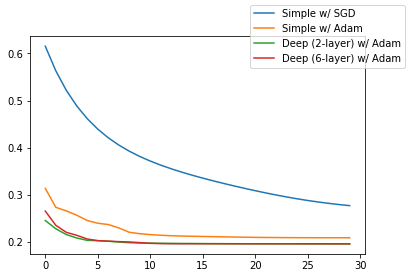

In [30]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(np.arange(epochs),simpleAE,  label = 'Simple w/ SGD')
sub.plot(np.arange(epochs),simpleAE1, label = 'Simple w/ Adam')
sub.plot(np.arange(epochs),deepAE, label = 'Deep (2-layer) w/ Adam')
sub.plot(np.arange(epochs),deepAE1, label = 'Deep (6-layer) w/ Adam')
fig.legend()

### Comparison of AE architectures with feature engineered dataset

#### Basic AE w/ TSA features

In [20]:
class autoencoder2(nn.Module):
    def __init__(self):
        super(autoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(35, 13),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(13, 35),
            nn.Sigmoid()) 

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
def preprocess(x, y):
    return x.view(-1,35).to(dev), y.to(dev)

In [36]:
x_train, x_valid, y_train, y_valid = train_test_split(scaled_df1.iloc[:100000], scaled_df1.iloc[:100000], test_size=0.33, random_state=42)
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train.values, y_train.values, x_valid.values, y_valid.values))
x_train, y_train, x_valid, y_valid = x_train.float(), y_train.float(), x_valid.float(), y_valid.float()
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [37]:
model = autoencoder2()
model.to(dev)
opt1 = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
simpleAE_ed = fit(epochs, model, loss_func, opt1, train_dl, valid_dl)

0 0.15542524325486384
1 0.1330017716595621
2 0.12358071852994687
3 0.12134318643627745
4 0.12013640852949836
5 0.11922035816040906
6 0.1186038601488778
7 0.11830568287769953
8 0.11817351314515778
9 0.11809839636629278
10 0.11803493072950479
11 0.118003826110652
12 0.11796236093477769
13 0.11794244261040832
14 0.11791596555709839
15 0.11789782470103466
16 0.11788164298642766
17 0.11786410925785701
18 0.1178481928651983
19 0.11783261449770494
20 0.11781676309217107
21 0.11780566596984864
22 0.11778696250373667
23 0.11777133213570623
24 0.11775690714156989
25 0.11774744177406485
26 0.11774040185863321
27 0.11772692710883689
28 0.11772219492630526
29 0.11770839673100096


In [40]:
class autoencoder3(nn.Module):
    def __init__(self):
        super(autoencoder3, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(35, 3),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(3, 35),
            nn.Sigmoid()) 

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
def preprocess(x, y):
    return x.view(-1,35).to(dev), y.to(dev)
model = autoencoder3()
model.to(dev)
opt1 = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
simpleAE_ed1 = fit(epochs, model, loss_func, opt1, train_dl, valid_dl)

0 0.18049194024548387
1 0.15102098090359659
2 0.1473470046339613
3 0.143951437588894
4 0.13999235530333085
5 0.1366622529969071
6 0.13426986752134382
7 0.1325131246248881
8 0.13121682799223697
9 0.13023262498595498
10 0.12944078761158567
11 0.12880684867049708
12 0.1282730374841979
13 0.12780357990842878
14 0.12739020001165793
15 0.12700787126656735
16 0.1266632669802868
17 0.12634942066669463
18 0.12608273115663818
19 0.12587054110657084
20 0.12572116792201996
21 0.12558745316664377
22 0.1255006782141599
23 0.12543083710381478
24 0.12537497831113412
25 0.12533319084210828
26 0.12530713788307074
27 0.12527308274399152
28 0.1252579463900942
29 0.12523770618799962


#### Deep AutoEncoder w/ TSA features

In [44]:
class deep_autoencoder1(nn.Module):
    def __init__(self):
        super(deep_autoencoder1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(35, 26),
            nn.ReLU(True),
            nn.Linear(26, 13),
            nn.ReLU(True),
            nn.Linear(13, 5),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(5, 13),
            nn.ReLU(True),
            nn.Linear(13, 26),
            nn.ReLU(True),
            nn.Linear(26, 35),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
model = deep_autoencoder1()
model.to(dev)
opt1 = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
deepAE_ed = fit(epochs, model, loss_func, opt1, train_dl, valid_dl)

0 0.14267463051550316
1 0.13841716249422595
2 0.12931717374469295
3 0.12356641965923887
4 0.12296843826228922
5 0.12272117885856917
6 0.1225782561211875
7 0.12246075998472444
8 0.1223881917180437
9 0.12213705055641405
10 0.12176700847076648
11 0.1211470121939977
12 0.11976834000421292
13 0.11921178272818074
14 0.11903793139349331
15 0.11892726133447705
16 0.11888989595030293
17 0.11885944359230273
18 0.11882691781990457
19 0.11880519064267477
20 0.11877735575943282
21 0.11873244151743975
22 0.11870291563055732
23 0.11867264552911122
24 0.11859710764523708
25 0.11848349631193912
26 0.11834015336903658
27 0.11821681090918454
28 0.11815993258447358
29 0.11813407987717427


#### Just by including out engineered TSA features, we've lowered the loss by nearly half!

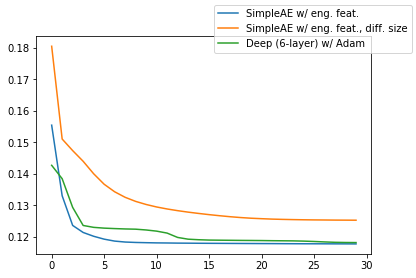

In [50]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(np.arange(epochs),simpleAE_ed,  label = 'SimpleAE w/ eng. feat.')
sub.plot(np.arange(epochs),simpleAE_ed1, label = 'SimpleAE w/ eng. feat., diff. size')
sub.plot(np.arange(epochs),deepAE_ed, label = 'Deep (6-layer) w/ Adam')
fig.legend()

### Improving the learning rate

**Future work**

I want to implement Smith 2015's one cycle learning schedule, which incorporates a cylical learning rate (and momentum) annealing. This is already implemnted in the fastai wrapper.

## Future work

- Entity Embedding for categorical values
- 2D Statistics (magnitude, radius, approx. covariance and correlation coefficient of 2 different streams). **Question: How best to define different streams? Are these simply different time windows of the same stream?**
- Feature Mapping with agglomerative hierarchical clustering
- Implement a Convolutional AutoEncoder
- Apply learning rate/momentum annealing
- Incorporate host events dataset

## Brief R&D proposal

Given 30-60 days, attempt to clearly define a brief proposal of R&D work that you would do toward embedding semantic meaning and ultimately quantifying data valuation to optimize the collection, retention, and inspection of the ‘right’ data for threat detection:

1. Create an autoencoder that is able to take in 'normal' netflow data, encode a lower-dimensional representation of said data and then decode this lower-dimensional embedding back into the original netflow data. This will force the autoencoder to find meaningful patterns present within the data in order to accurately encode the information in a lower dimension.
2. Once the autoencoder is able to effectively reproduce the 'normal' input data, the lower-dimensional embedding can serve as a type of virtual 'fingerprint' of normal traffic behavior. By running new data through the system, the autoencoder will be able to distill all new incoming data down to its fingerprint and identify if it looks normal or abnormal. 
3. After producing a functioning autoencoder prototype, we will aim to create a light-weight version that can be run without GPUs (for example on a router) and can self update in order to have a dynamic definition of normal network behavior.

## Resources


Good [resource](https://www.jeremyjordan.me/autoencoders/) for autoencoders  
Good [resource](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf) for variational autoencoders (VAEs)  
Outlook inspired by [Kitsune](https://arxiv.org/pdf/1802.09089.pdf) paper (Mirsky 2018)  
Insight from Cyber Reboot's [work](https://blog.cyberreboot.org/deep-session-learning-for-cyber-security-e7c0f6804b81) on using RNN autoencoders on network traffic data.  
Good [resource](https://towardsdatascience.com/deep-learning-structured-data-8d6a278f3088) for embeddings of structured data.

# Instructions:

For the below, document all of your steps and your intuition (we recommend using Jupyter Notebooks) so that your process is understood and your results can be reproduced. Plan on presenting your results (can be graphs/plots in your Notebook, Tableau, PowerPoint, etc.). Use whatever you feel most comfortable using for your analysis (we recommend Python or Scala and supporting ML/DL libraries). This mini project is intentionally vague/open-ended, we are more interested in seeing how you approach a problem (your creativity, intuition, and analytic qualities).

0.	Download a day (or more) of the LANL 2017 dataset (recommend starting with a day). For example:

Netflow:
https://csr.lanl.gov/data/unified-host-network-dataset-2017/netflow/netflow_day-03.bz2

and/or

Host Events:
https://csr.lanl.gov/data/unified-host-network-dataset-2017/wls/wls_day-03.bz2

We recommend starting with whichever type of data you are most comfortable with (the netflow is a good starting place). It is possible to join and use the two datasets, which can increase the number of features/information about what is happening – but this can also add complexity, it may be good to consider this as a second iteration of your work as time allows.

Documentation of the data sets/fields:
https://csr.lanl.gov/data/2017.html
Note the point about the anonymization done on the data to protect from disclosing information about LANL’s operational network.

1.	Load the data
2.	Explore the data (e.g., statistical analysis/distribution), document your exploration methods and your resulting observations
3.	Clearly define a ‘mini’ challenge problem toward embedding semantic meaning/context around entities, log entries (actions), and/or set of these things – remembering that the end goal is to formulate valuations for data based on its ability to provide meaning to the Security Operations Center (SOC) analysts, where high-value information is tied to the ability to detect, characterize, and respond to a threat or security concern within the environment
4.	Extract, transform, engineer meaningful features
5.	Select, build, train, cross validate one or more model toward a solution to your challenge problem
6.	Document results, metrics, successes/failures/challenges/questions
7.	Document next steps toward solving this ‘mini’ challenge problem given more time/more data
8.	Expand upon your ‘mini’ challenge problem – given 30-60 days, attempt to clearly define a brief proposal of R&D work that you would do toward embedding semantic meaning and ultimately quantifying data valuation to optimize the collection, retention, and inspection of the ‘right’ data for threat detection.
